### DATA PREPROCESSING

Initially, we import the essential libraries required for the pipeline execution. Subsequently, we load the dataset containing the compounds associated with our two targets of interest, COX-1 and COX-2. We proceed by dropping the non-essential columns (ChEMBL ID, Smiles). Finally, the dataset is partitioned into training (70%), validation (15%), and testing (15%) sets.


In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
import xgboost as xgb

In [2]:
# Load the dataset containing chemical compounds and their descriptors
# The 'train_files/cox1_cox2_good.csv' file includes the target labels and features
data = pd.read_csv('train_files/cox1_cox2_good.csv', delimiter=',')

# Drop non-predictive identifier columns ('ChEMBL ID', 'Smiles')
# We only want to keep physicochemical properties for the model training
dataset = data.drop(['ChEMBL ID', 'Smiles'], axis=1)

# Identify columns that contain missing values (NaNs)
# This step is crucial to decide on the imputation strategy later
nan_columns = dataset.columns[dataset.isna().any()].tolist()

# Print the names of the columns with missing values for inspection
print("\n".join(nan_columns))

# Define specific percentiles to get a better understanding of the data distribution
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Generate descriptive statistics (mean, std, min, max, percentiles) only for columns with NaNs
# This helps us understand the spread of data in these problematic columns
nan_col_desc = dataset[nan_columns].describe(percentiles=percentiles)

# Display the statistics
print(nan_col_desc)

MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
       MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  \
count      11072.000000      11072.000000         11072.000000   
mean           0.295293         -0.417250             0.437641   
std            0.107477          0.098352             0.095233   
min           -0.017096         -1.000000             0.062225   
25%            0.230801         -0.496078             0.398540   
50%            0.277551         -0.463454             0.465725   
75%            0.339260         -0.347971             0.496687   
90%            0.434403         -0.236917             0.504862   
95%            0.434699         -0.232452             0.507939   
max            1.000000         -0.062225             1.000000   

       MinAbsPartialCharge   BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  \
count         11072.00

In [2]:
data = pd.read_csv('train_files/cox1_cox2_good.csv', delimiter=',')
dataset = data.drop(['ChEMBL ID', 'Smiles'], axis=1)
dataset.fillna(dataset.mean(), inplace = True)
print("Dataset's shape is:",dataset.shape)

# Separate the dataset into two DataFrames: one for 0s and one for 1s
zeros = dataset[dataset['Class'] == 0]
ones = dataset[dataset['Class'] == 1]
ratio = zeros.shape[0]/ones.shape[0]

# Get the number of zeros and ones for each set
zeros_and_ones = int(((dataset.shape[0]*0.2)//2))
print("Each validation's and testing's set shape is :", (zeros_and_ones, dataset.shape[1]))

# Get 2 datasets with zeros and ones
sampled_zeros = zeros.sample(n=zeros_and_ones, random_state=42)
sampled_ones = ones.sample(n=zeros_and_ones, random_state=42)

# Split the 2 datasets in half for validation and testing sets
first_half_zeros = sampled_zeros.iloc[:sampled_zeros.shape[0]//2]
first_half_ones = sampled_ones.iloc[:sampled_ones.shape[0]//2]

second_half_zeros = sampled_zeros.iloc[sampled_zeros.shape[0]//2:]
second_half_ones= sampled_ones.iloc[sampled_ones.shape[0]//2:]

print(f"validation set has {first_half_zeros.shape[0]} zeros and {first_half_ones.shape[0]} ones")
print(f"testing set has {second_half_zeros.shape[0]} zeros and {second_half_ones.shape[0]} ones")

validation_set = pd.concat([first_half_zeros, first_half_ones], ignore_index=True)
validation_set = shuffle(validation_set, random_state=42).reset_index(drop=True)
print("Validation's set shape is :",validation_set.shape)

testing_set = pd.concat([second_half_zeros, second_half_ones], ignore_index=True)
testing_set = shuffle(testing_set, random_state=42).reset_index(drop=True)
print("Testing's set shape is :",testing_set.shape)

indices_to_exclude = sampled_zeros.index.append(sampled_ones.index)
training_set = dataset.drop(indices_to_exclude)
training_set = shuffle(training_set, random_state=42).reset_index(drop=True)
print("Training's set shape is :", training_set.shape)

Dataset's shape is: (11082, 210)
Each validation's and testing's set shape is : (1108, 210)
validation set has 554 zeros and 554 ones
testing set has 554 zeros and 554 ones
Validation's set shape is : (1108, 210)
Testing's set shape is : (1108, 210)
Training's set shape is : (8866, 210)


In [24]:
print((training_set['Class'] == 0).sum())
print((training_set['Class'] == 1).sum())

1956
6910


### DATA SPLIT

Feature & Target Separation In this step, we decouple the dataset into the Feature Matrix (X) and the Target Vector (y).

X (Features): Contains all independent variables (molecular descriptors).
y (Target): Contains the dependent variable (Class Label) we aim to predict.

In [3]:
X_train = training_set.drop(['Class'], axis = 1)
y_train = training_set['Class']
X_validation = validation_set.drop(['Class'], axis = 1)
y_validation = validation_set['Class']
X_testing = testing_set.drop(['Class'], axis = 1)
y_testing = testing_set['Class']
print("Training Set Shapes:")
print("X_train shape and type:", X_train.shape, type(X_train))
print("y_train shape and type:", y_train.shape, type(y_train))

print("\nValidation Set Shapes:")
print("X_validation shape and type:", X_validation.shape, type(X_validation))
print("y_validation shape and type:", y_validation.shape, type(y_validation))

print("\nTesting Set Shapes:")
print("X_testing shape and type:", X_testing.shape, type(X_testing))
print("y_testing shape and type:", y_testing.shape, type(y_testing))

Training Set Shapes:
X_train shape and type: (8866, 209) <class 'pandas.core.frame.DataFrame'>
y_train shape and type: (8866,) <class 'pandas.core.series.Series'>

Validation Set Shapes:
X_validation shape and type: (1108, 209) <class 'pandas.core.frame.DataFrame'>
y_validation shape and type: (1108,) <class 'pandas.core.series.Series'>

Testing Set Shapes:
X_testing shape and type: (1108, 209) <class 'pandas.core.frame.DataFrame'>
y_testing shape and type: (1108,) <class 'pandas.core.series.Series'>


### Scaling the Sets

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_testing_scaled = scaler.transform(X_testing)

### Model Benchmarking & Scaler Selection

Here, we implement a comprehensive evaluation pipeline. We train and test every available model using each feature scaler from scikit-learn. We record key performance metrics (Accuracy, Precision, Recall, F1) and visualize the Confusion Matrix for every combination. The process concludes by identifying and reporting the optimal scaler for each specific model based on the achieved metrics.

DecisionTreeClassifier with StandardScaler transformation
Accuracy: 0.44855595667870035, Precision: 0.466030989272944, Recall: 0.7057761732851986, F1: 0.5613783201722901
Specificity: 0.19133574007220217


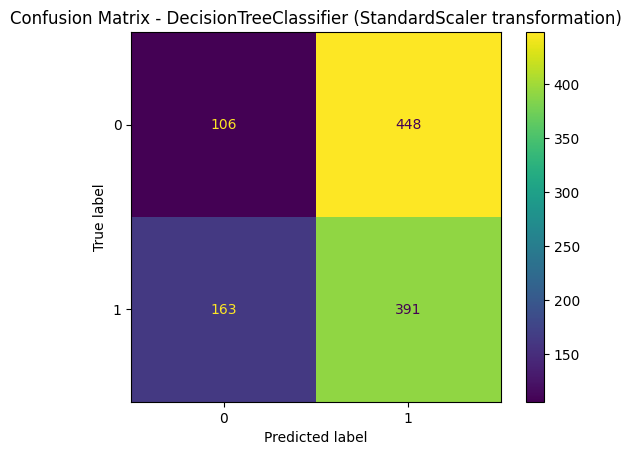

RandomForestClassifier with StandardScaler transformation
Accuracy: 0.48465703971119134, Precision: 0.4908896034297964, Recall: 0.8267148014440433, F1: 0.6160053799596503
Specificity: 0.14259927797833935


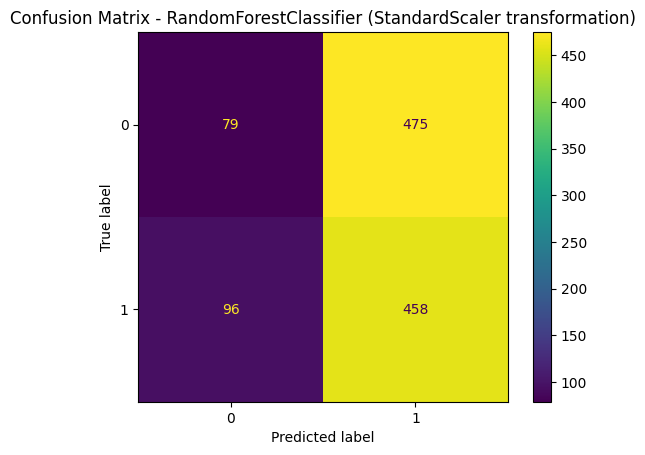

MLPClassifier with StandardScaler transformation
Accuracy: 0.5063176895306859, Precision: 0.5036649214659686, Recall: 0.868231046931408, F1: 0.6375082836315441
Specificity: 0.1444043321299639


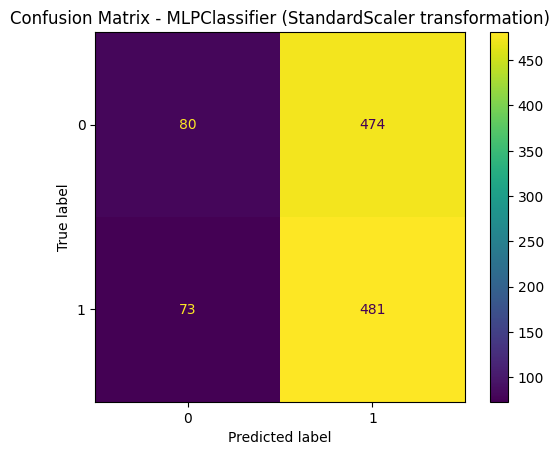

AdaBoostClassifier with StandardScaler transformation
Accuracy: 0.5415162454873647, Precision: 0.5224609375, Recall: 0.9657039711191335, F1: 0.6780735107731305
Specificity: 0.11732851985559567


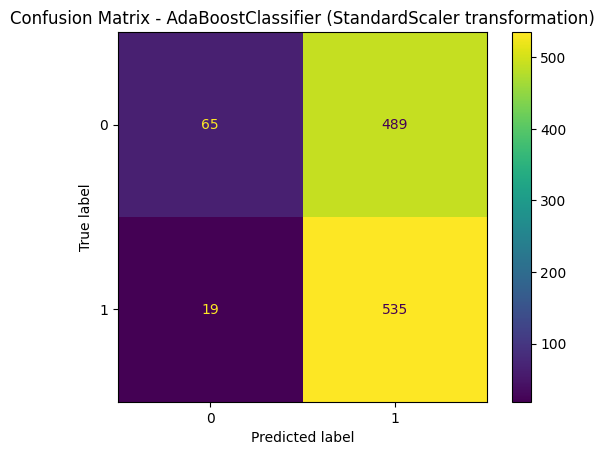

XGBClassifier with StandardScaler transformation
Accuracy: 0.4936823104693141, Precision: 0.49637305699481865, Recall: 0.8646209386281588, F1: 0.6306780776826859
Specificity: 0.12274368231046931


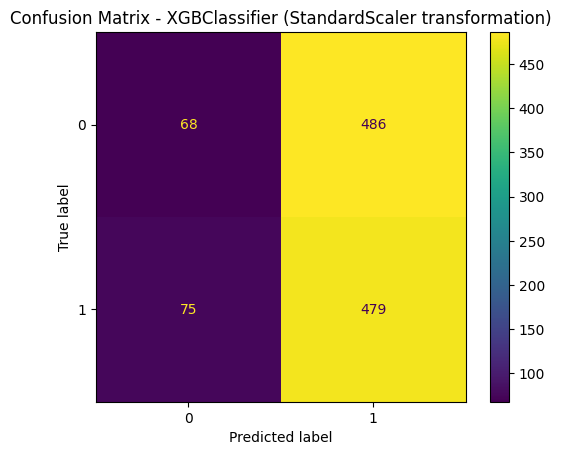

GradientBoostingClassifier with StandardScaler transformation
Accuracy: 0.51985559566787, Precision: 0.5103189493433395, Recall: 0.9819494584837545, F1: 0.671604938271605
Specificity: 0.05776173285198556


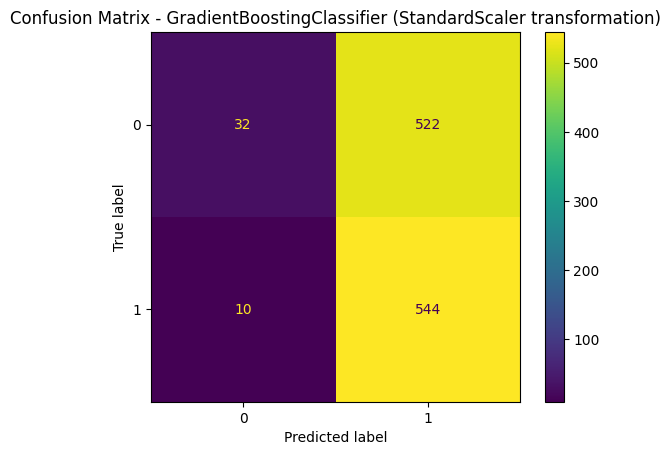

HistGradientBoostingClassifier with StandardScaler transformation
Accuracy: 0.5045126353790613, Precision: 0.5024679170779862, Recall: 0.9187725631768953, F1: 0.6496490108487556
Specificity: 0.09025270758122744


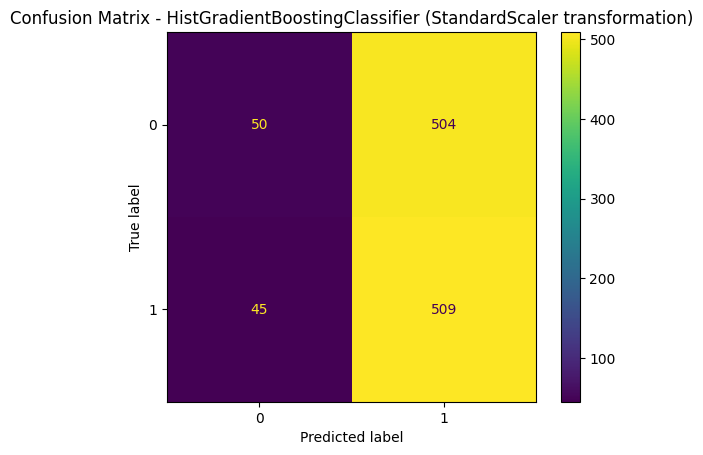

SVC with StandardScaler transformation
Accuracy: 0.5252707581227437, Precision: 0.5130597014925373, Recall: 0.9927797833935018, F1: 0.6765067650676506
Specificity: 0.05776173285198556


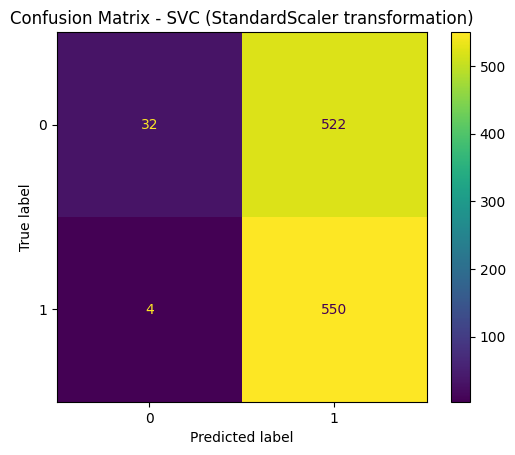

SVC with StandardScaler transformation
Accuracy: 0.5252707581227437, Precision: 0.5130597014925373, Recall: 0.9927797833935018, F1: 0.6765067650676506
Specificity: 0.05776173285198556


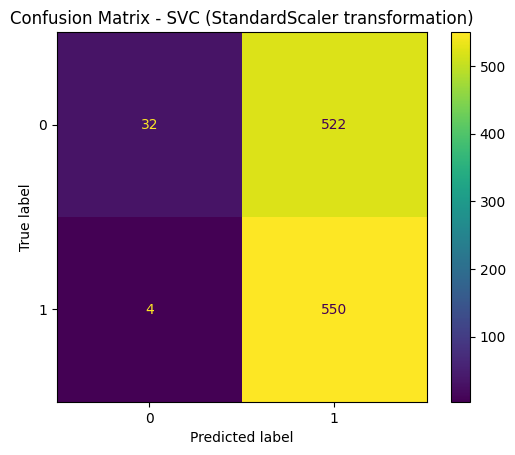

KNeighborsClassifier with StandardScaler transformation
Accuracy: 0.5288808664259927, Precision: 0.5168421052631579, Recall: 0.8862815884476535, F1: 0.6529255319148936
Specificity: 0.17148014440433212


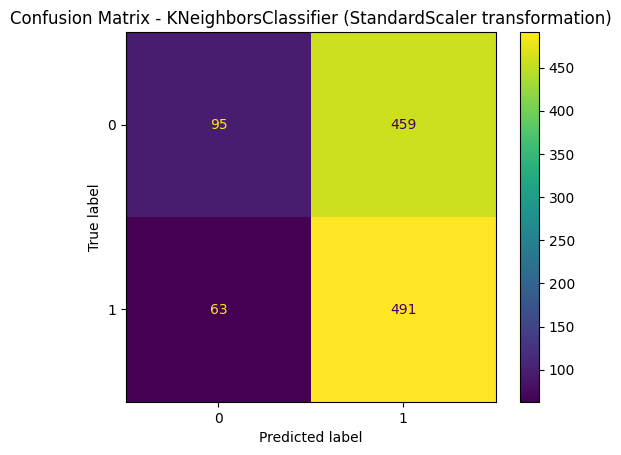

GaussianNB with StandardScaler transformation
Accuracy: 0.516245487364621, Precision: 0.6285714285714286, Recall: 0.07942238267148015, F1: 0.14102564102564102
Specificity: 0.9530685920577617


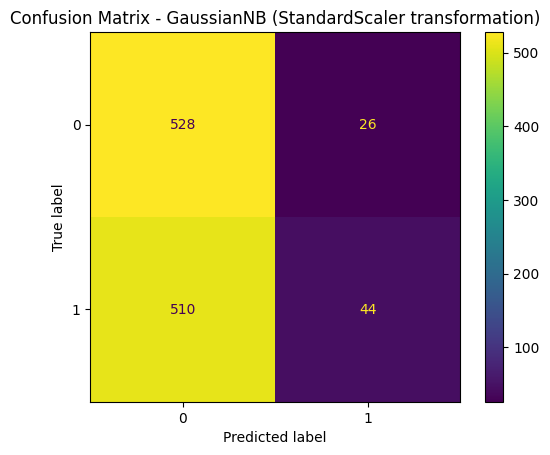

LogisticRegression with StandardScaler transformation
Accuracy: 0.5288808664259927, Precision: 0.5152963671128107, Recall: 0.9729241877256317, F1: 0.67375
Specificity: 0.08483754512635379


C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


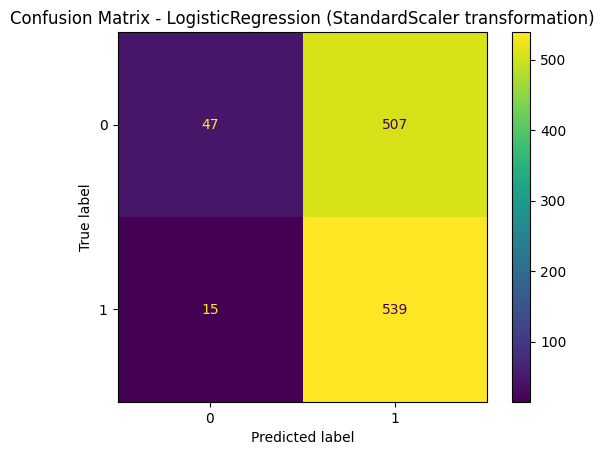

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis with StandardScaler transformation
Accuracy: 0.5351985559566786, Precision: 0.7142857142857143, Recall: 0.11732851985559567, F1: 0.20155038759689922
Specificity: 0.9530685920577617


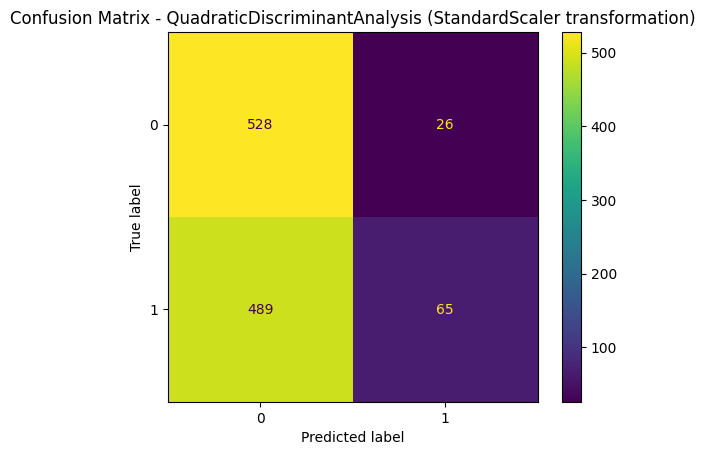

In [6]:
models = [DecisionTreeClassifier(), 
            RandomForestClassifier(), 
            MLPClassifier(),
            AdaBoostClassifier(),
            xgb.XGBClassifier(),
            GradientBoostingClassifier(),
            HistGradientBoostingClassifier(),
            svm.SVC(),
            svm.SVC(kernel = 'rbf'),
            KNeighborsClassifier(),
            GaussianNB(),
            LogisticRegression(),
            QuadraticDiscriminantAnalysis()
            ]
best_scalers = {}  # Dictionary to store the best scaler for each model

for i, model in enumerate(models):
    # Create and fit the model
    model_instance = model
    model_instance.fit(X_train_scaled, y_train)

    # Make predictions
    predictions = model_instance.predict(X_validation_scaled)
    acc = accuracy_score(y_validation, predictions)
    precision = precision_score(y_validation, predictions)
    recall = recall_score(y_validation, predictions)
    f1 = f1_score(y_validation, predictions)

    print(f'{type(model_instance).__name__} with StandardScaler transformation\n'
          f'Accuracy: {acc:}, Precision: {precision:}, Recall: {recall:}, F1: {f1:}')

    # Compute the confusion matrix
    cm = confusion_matrix(y_validation, predictions)

    # Extract values from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate Specificity
    specificity = tn / (fp + tn)
    print("Specificity:", specificity)

    cm = confusion_matrix(y_validation, predictions)
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_instance.classes_)

    # Set the title for the subplot
    disp.plot()
    plt.title(f'Confusion Matrix - {type(model_instance).__name__} (StandardScaler transformation)')
    # Show the plot
    plt.show()

### BEST MODEL

Comprehensive Performance Evaluation We proceed by retraining all candidate models to establish a final ranking based on accuracy. However, due to potential dataset bias, high accuracy does not always imply optimal performance in terms of the Confusion Matrix (True/False Positives/Negatives). Therefore, we conduct a holistic evaluation across all four key metrics and visualize the results using a bar chart, sorted by accuracy, to identify the most robust model.

DecisionTreeClassifier with StandardScaler() transformation:
  accuracy_score : 0.4495
Specificity: 0.1931407942238267
RandomForestClassifier with StandardScaler() transformation:
  accuracy_score : 0.4892
Specificity: 0.14259927797833935
MLPClassifier with StandardScaler() transformation:
  accuracy_score : 0.5108
Specificity: 0.13537906137184116
AdaBoostClassifier with StandardScaler() transformation:
  accuracy_score : 0.5415
Specificity: 0.11732851985559567
XGBClassifier with StandardScaler() transformation:
  accuracy_score : 0.4937
Specificity: 0.12274368231046931
GradientBoostingClassifier with StandardScaler() transformation:
  accuracy_score : 0.5199
Specificity: 0.05776173285198556
HistGradientBoostingClassifier with StandardScaler() transformation:
  accuracy_score : 0.5045
Specificity: 0.09025270758122744
SVC with StandardScaler() transformation:
  accuracy_score : 0.5253
Specificity: 0.05776173285198556
SVC with StandardScaler() transformation:
  accuracy_score : 0.5253
Sp

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LogisticRegression with StandardScaler() transformation:
  accuracy_score : 0.5289
Specificity: 0.08483754512635379
QuadraticDiscriminantAnalysis with StandardScaler() transformation:
  accuracy_score : 0.5352
Specificity: 0.9530685920577617


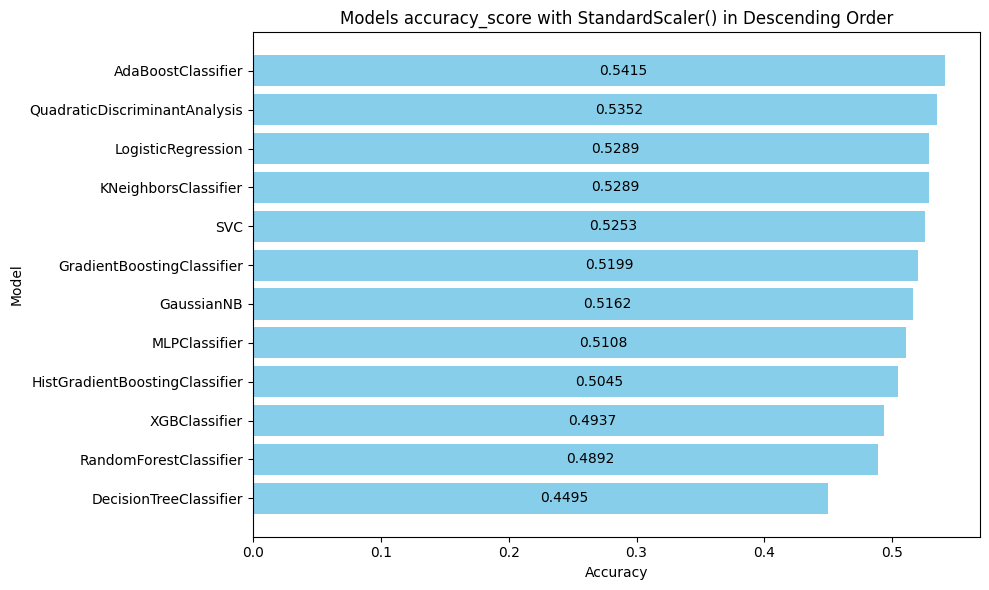

DecisionTreeClassifier with StandardScaler() transformation:
  precision_score : 0.4650
Specificity: 0.18592057761732853
RandomForestClassifier with StandardScaler() transformation:
  precision_score : 0.4905
Specificity: 0.1299638989169675
MLPClassifier with StandardScaler() transformation:
  precision_score : 0.5016
Specificity: 0.1552346570397112
AdaBoostClassifier with StandardScaler() transformation:
  precision_score : 0.5225
Specificity: 0.11732851985559567
XGBClassifier with StandardScaler() transformation:
  precision_score : 0.4964
Specificity: 0.12274368231046931
GradientBoostingClassifier with StandardScaler() transformation:
  precision_score : 0.5103
Specificity: 0.05776173285198556
HistGradientBoostingClassifier with StandardScaler() transformation:
  precision_score : 0.5025
Specificity: 0.09025270758122744
SVC with StandardScaler() transformation:
  precision_score : 0.5131
Specificity: 0.05776173285198556
SVC with StandardScaler() transformation:
  precision_score : 0

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LogisticRegression with StandardScaler() transformation:
  precision_score : 0.5153
Specificity: 0.08483754512635379
QuadraticDiscriminantAnalysis with StandardScaler() transformation:
  precision_score : 0.7143
Specificity: 0.9530685920577617


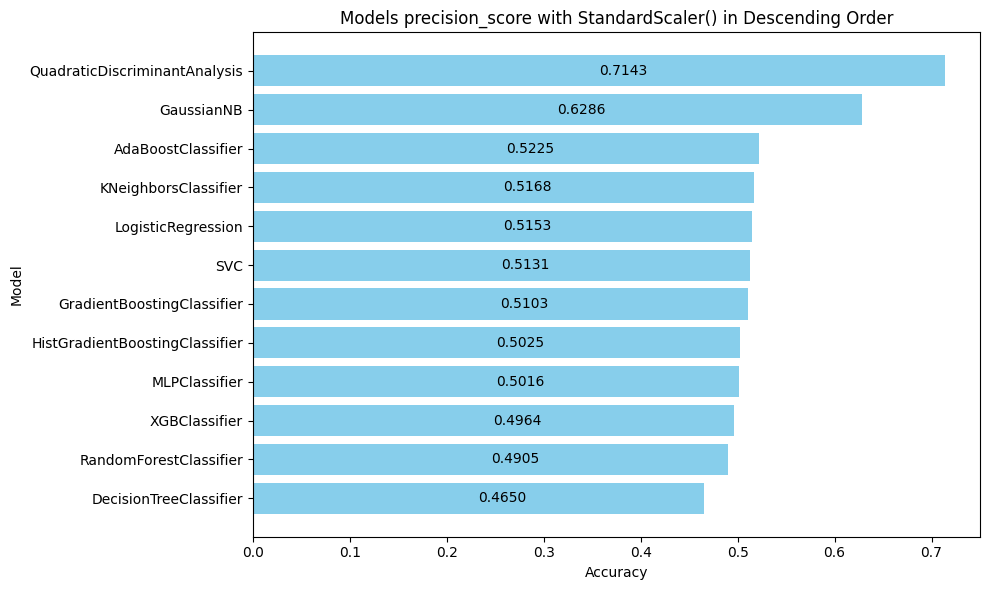

DecisionTreeClassifier with StandardScaler() transformation:
  recall_score : 0.7166
Specificity: 0.18772563176895307
RandomForestClassifier with StandardScaler() transformation:
  recall_score : 0.8267
Specificity: 0.13357400722021662
MLPClassifier with StandardScaler() transformation:
  recall_score : 0.8809
Specificity: 0.14620938628158844
AdaBoostClassifier with StandardScaler() transformation:
  recall_score : 0.9657
Specificity: 0.11732851985559567
XGBClassifier with StandardScaler() transformation:
  recall_score : 0.8646
Specificity: 0.12274368231046931
GradientBoostingClassifier with StandardScaler() transformation:
  recall_score : 0.9838
Specificity: 0.05776173285198556
HistGradientBoostingClassifier with StandardScaler() transformation:
  recall_score : 0.9188
Specificity: 0.09025270758122744
SVC with StandardScaler() transformation:
  recall_score : 0.9928
Specificity: 0.05776173285198556
SVC with StandardScaler() transformation:
  recall_score : 0.9928
Specificity: 0.0577

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LogisticRegression with StandardScaler() transformation:
  recall_score : 0.9729
Specificity: 0.08483754512635379
QuadraticDiscriminantAnalysis with StandardScaler() transformation:
  recall_score : 0.1173
Specificity: 0.9530685920577617


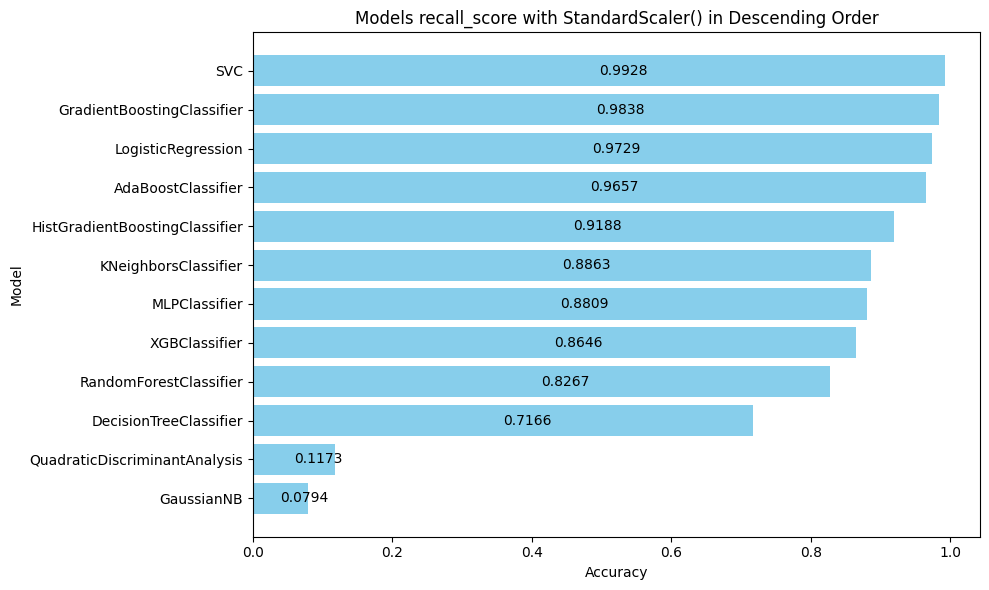

DecisionTreeClassifier with StandardScaler() transformation:
  f1_score : 0.5614
Specificity: 0.19133574007220217
RandomForestClassifier with StandardScaler() transformation:
  f1_score : 0.6148
Specificity: 0.1371841155234657
MLPClassifier with StandardScaler() transformation:
  f1_score : 0.6322
Specificity: 0.1371841155234657
AdaBoostClassifier with StandardScaler() transformation:
  f1_score : 0.6781
Specificity: 0.11732851985559567
XGBClassifier with StandardScaler() transformation:
  f1_score : 0.6307
Specificity: 0.12274368231046931
GradientBoostingClassifier with StandardScaler() transformation:
  f1_score : 0.6724
Specificity: 0.05776173285198556
HistGradientBoostingClassifier with StandardScaler() transformation:
  f1_score : 0.6496
Specificity: 0.09025270758122744
SVC with StandardScaler() transformation:
  f1_score : 0.6765
Specificity: 0.05776173285198556
SVC with StandardScaler() transformation:
  f1_score : 0.6765
Specificity: 0.05776173285198556
KNeighborsClassifier wit

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LogisticRegression with StandardScaler() transformation:
  f1_score : 0.6737
Specificity: 0.08483754512635379
QuadraticDiscriminantAnalysis with StandardScaler() transformation:
  f1_score : 0.2016
Specificity: 0.9530685920577617


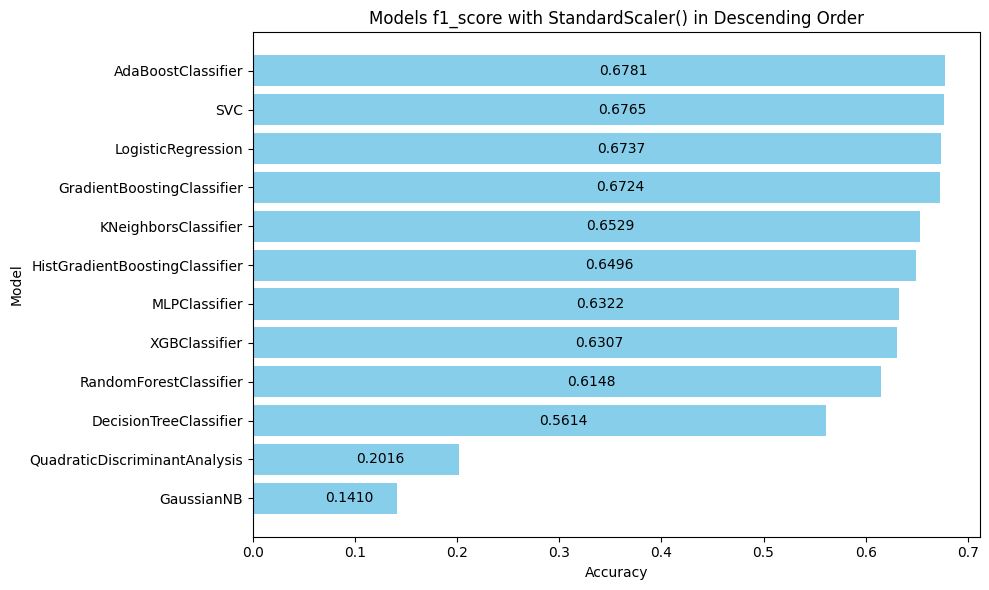

In [7]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          MLPClassifier(),
          AdaBoostClassifier(),
          xgb.XGBClassifier(),
          GradientBoostingClassifier(),
          HistGradientBoostingClassifier(),
          svm.SVC(),
          svm.SVC(kernel='rbf'),
          KNeighborsClassifier(),
          GaussianNB(),
          LogisticRegression(),
          QuadraticDiscriminantAnalysis()
          ]
metrics = [accuracy_score, precision_score, recall_score, f1_score]

for metric in metrics:
    accuracies = {}
    # Loop over models
    for i, model in enumerate(models):

        # Create and fit the model
        model_instance = model
        model_instance.fit(X_train_scaled, y_train)

        # Make predictions
        predictions = model_instance.predict(X_validation_scaled)
        acc = metric(y_validation, predictions)

        # Compute the confusion matrix
        cm = confusion_matrix(y_validation, predictions)

        # Extract values from confusion matrix
        tn, fp, fn, tp = cm.ravel()

        print(f'{type(model_instance).__name__} with {scaler} transformation:')
        print(f'  {metric.__name__} : {acc:.4f}')
        # Calculate Specificity
        specificity = tn / (fp + tn)
        print("Specificity:", specificity)

        accuracies[type(model_instance).__name__] = acc

    # Sort the accuracies dictionary by values in descending order
    sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1]))

    # Extract model names and accuracies from the sorted dictionary
    model_names = list(sorted_accuracies.keys())
    model_accuracies = list(sorted_accuracies.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(model_names, model_accuracies, color='skyblue')

    # Add labels and title
    plt.xlabel('Accuracy')
    plt.ylabel('Model')
    plt.title(f'Models {metric.__name__} with {scaler} in Descending Order')

    # Annotate the bars with accuracy values
    for bar, acc in zip(bars, model_accuracies):
        plt.annotate(f'{acc:.4f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2), va='center')

    # Show the chart
    plt.tight_layout()
    plt.show()

### Hyperparameter Tuning & Performance Benchmarking

We proceed to optimize each model using Grid Search CV to identify the best hyperparameter configuration. Following optimization, we rank the models based on their tuned accuracy.

Additionally, we present the baseline accuracies (using default parameters) alongside the tuned results. This allows us to quantify the performance gain achieved through hyperparameter tuning.

Original Accuracy for DecisionTreeClassifier: 0.4504
Grid search for DecisionTreeClassifier...
Best Parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 20, 'splitter': 'random'}
Best Accuracy for DecisionTreeClassifier: 0.6862173489222975
Test set accuracy: 0.49


Original Accuracy for RandomForestClassifier: 0.4792
Grid search for RandomForestClassifier...
Best Parameters for RandomForestClassifier: {'criterion': 'gini', 'n_estimators': 200}
Best Accuracy for RandomForestClassifier: 0.7003165991691735
Test set accuracy: 0.49


Original Accuracy for MLPClassifier: 0.4991
Grid search for MLPClassifier...
Best Parameters for MLPClassifier: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 25)}
Best Accuracy for MLPClassifier: 0.7038136242561127
Test set accuracy: 0.51


Original Accuracy for AdaBoostClassifier: 0.5415
Grid search for AdaBoostClassifier...
Best Parameters for AdaBoostClassifier: {'algorithm': 'SAMME.R', 'learning_rate': 0.1

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Original Accuracy for LogisticRegression: 0.5289
Grid search for LogisticRegression...


C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Best Parameters for LogisticRegression: {'solver': 'saga'}
Best Accuracy for LogisticRegression: 0.7757724377500157
Test set accuracy: 0.51


Original Accuracy for QuadraticDiscriminantAnalysis: 0.5406
Grid search for QuadraticDiscriminantAnalysis...


C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Parameters for QuadraticDiscriminantAnalysis: {'reg_param': 0.7}
Best Accuracy for QuadraticDiscriminantAnalysis: 0.6648987601190601
Test set accuracy: 0.65




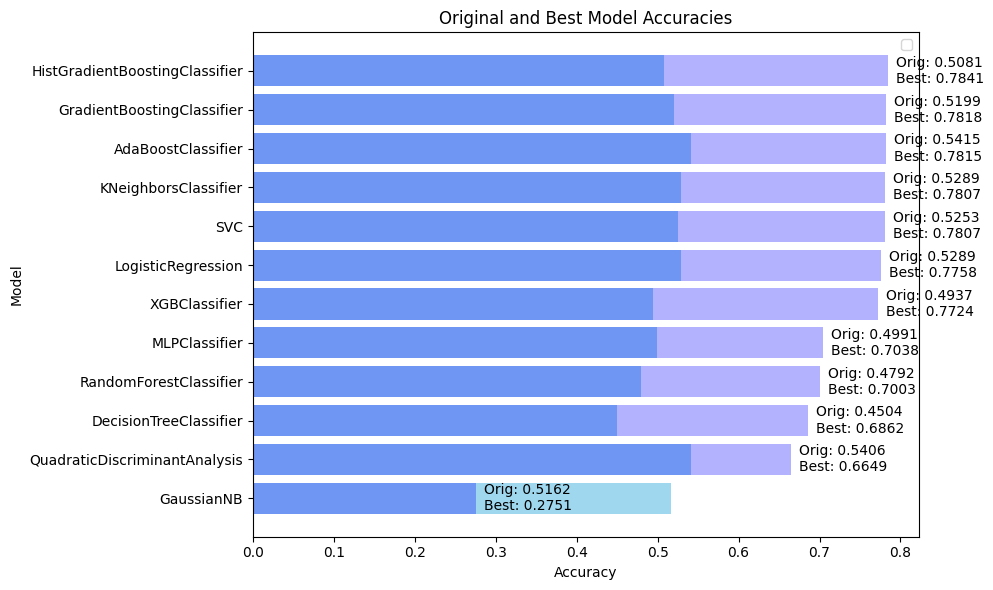

In [8]:
from sklearn.pipeline import make_pipeline
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          MLPClassifier(),
          AdaBoostClassifier(),
          xgb.XGBClassifier(),
          GradientBoostingClassifier(),
          HistGradientBoostingClassifier(),
          svm.SVC(),
          KNeighborsClassifier(),
          GaussianNB(),
          LogisticRegression(),
          QuadraticDiscriminantAnalysis()
          ]

# Define parameter grids for each model
param_grids = {
    'DecisionTreeClassifier': {'criterion' : ['gini', 'entropy'], 'splitter' : ["best", "random"], 'max_depth' : [20, 50, 100]},
    'RandomForestClassifier': {'n_estimators': [100, 150, 200], 'criterion': ['gini', 'entropy']},
    'MLPClassifier': {'hidden_layer_sizes': [(100, 50, 25), (150, 100)], 'activation': ['logistic', 'relu'], 'alpha':[0.001, 0.01]},
    'AdaBoostClassifier': {'n_estimators' : [150, 200],'learning_rate' : [0.1],'algorithm' : ['SAMME', 'SAMME.R'],'random_state' : [42]},
    'XGBClassifier': {'n_estimators' : [100, 150, 200], 'max_depth': [10, 50, 60], 'max_leaves' : [5, 10, 20]},
    'GradientBoostingClassifier': {'n_estimators' : [100, 150, 200], 'min_samples_split': [5, 10, 40]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_depth': [10, 50, 100], 'l2_regularization' : [0.01, 0.001]},
    'SVC': {'kernel': ['poly', 'rbf'], 'degree' : [1, 2], 'C' : [1.5, 2.3], 'tol' : [1e-2, 1e-3], 'random_state' : [42]},
    'KNeighborsClassifier': {'n_neighbors': [10, 20, 50], 'leaf_size': [50, 100]},
    'GaussianNB': {},
    'LogisticRegression': {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
    'QuadraticDiscriminantAnalysis': {'reg_param': [0.1, 0.5, 0.7]}
}

# Dictionary to store best scores for each model
best_scores = {}
original_accuracies = {}
best_estimators = {}

# Loop over models
for model in models:
    # Get the model name
    model_name = type(model).__name__

    # Create a pipeline with StandardScaler for each model
    pipeline = make_pipeline(StandardScaler(), model)

    # Fit the original model
    pipeline.fit(X_train_scaled, y_train)

    # Make predictions on the validation set
    predictions = pipeline.predict(X_validation_scaled)

    # Calculate and store the original accuracy
    original_accuracy = accuracy_score(y_validation, predictions)
    original_accuracies[model_name] = original_accuracy

    # Print the original accuracy
    print(f'Original Accuracy for {model_name}: {original_accuracy:.4f}')

    # Print current model
    print(f"Grid search for {model_name}...")

    # Get the parameter grid for the current model
    param_grid = param_grids.get(model_name, {})

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs = -1)

    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)

    # Store the best score in the dictionary
    best_scores[model_name] = grid_search.best_score_

    # Store the best estimators in the dictionary
    best_estimators[model_name] = grid_search.best_estimator_

    # Evaluate the model on the test set
    test_accuracy = grid_search.score(X_testing_scaled, y_testing)

    # Print the best parameters and the corresponding accuracy
    print(f"Best Parameters for {model_name}:", grid_search.best_params_)
    print(f"Best Accuracy for {model_name}:", grid_search.best_score_)
    print(f"Test set accuracy: {test_accuracy:.2f}")
    print("\n")

# Sort models based on best scores
sorted_models = sorted(best_scores.keys(), key=lambda x: best_scores[x])

# Create a barh plot with transparency in descending order
plt.figure(figsize=(10, 6))

# Plot original accuracies with transparency
bars_original = plt.barh(sorted_models, [original_accuracies[model] for model in sorted_models], color='skyblue', alpha=0.8)

# Plot best scores after grid search in descending order
bars_best = plt.barh(sorted_models, [best_scores[model] for model in sorted_models], color='blue', alpha=0.3)

# Add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Original and Best Model Accuracies')

# Add legend
plt.legend()

# Add text labels to the bars
for bar, orig_acc, best_acc in zip(bars_best, [original_accuracies[model] for model in sorted_models], [best_scores[model] for model in sorted_models]):
    plt.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'Orig: {orig_acc:.4f}\nBest: {best_acc:.4f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()

### Cross-Validation of the Best Estimator

We isolate the best-performing model (HistGradientBoostingClassifier) with its optimal hyperparameters and subject it to a 5-Fold Cross-Validation procedure (KFold). We calculate the accuracy for each fold and report the Mean Accuracy to establish a reliable baseline of the model's expected performance on the training distribution.

In [18]:
demo = HistGradientBoostingClassifier(l2_regularization = 0.01, learning_rate = 0.01, max_depth = 10)
# demo.fit(X_train_scaled, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cross_val_results = cross_val_score(demo, X_train_scaled, y_train, cv=kf, scoring='accuracy')

# Calculate the mean accuracy
mean_accuracy = cross_val_results.mean()

# Print the results
print(f'{type(demo).__name__} Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'{type(demo).__name__} Mean Accuracy: {cross_val_results.mean()}')

HistGradientBoostingClassifier Cross-Validation Results (Accuracy): [0.77057497 0.79244219 0.79864636 0.77439368 0.78398195]
HistGradientBoostingClassifier Mean Accuracy: 0.7840078313624574


### Fold-wise Confusion Matrix Analysis

To gain deeper insight into the model's classification behavior, we perform a 5-Fold Cross-Validation where we explicitly visualize the **Confusion Matrix for each fold**.

Unlike a simple accuracy score, this approach allows us to observe:

**Stability**: Whether the model makes consistent types of errors (False Positives vs. False Negatives) across different data subsets.

**Average Performance**: We compute and print the Mean Confusion Matrix to obtain an aggregated view of the model's predictive power, minimizing the bias from any single random train-test split.

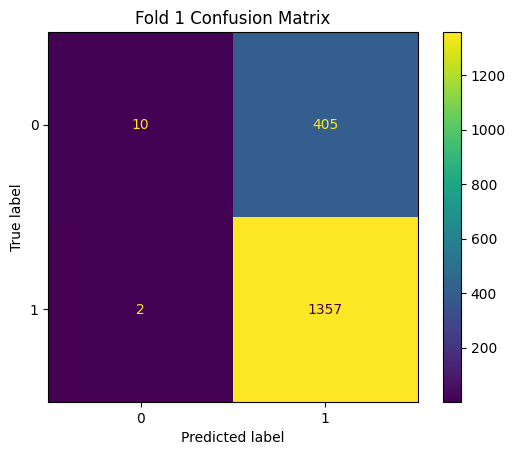

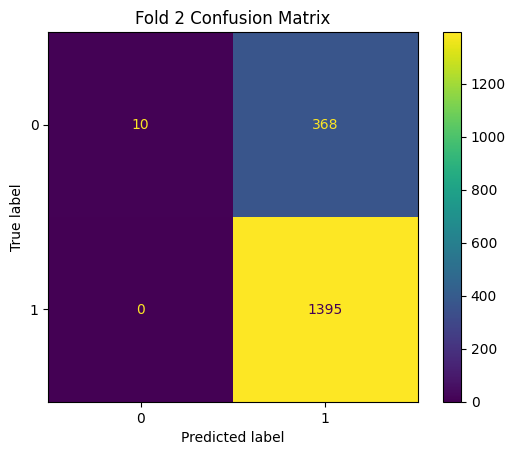

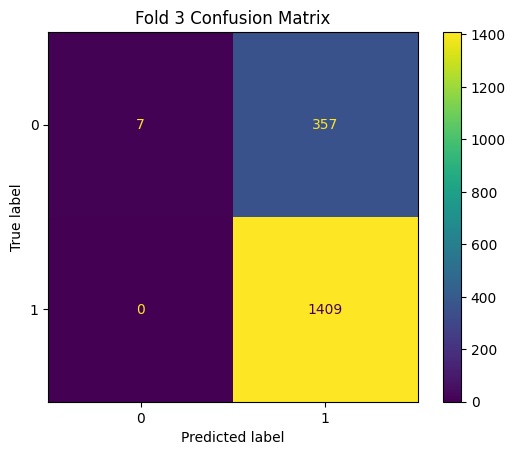

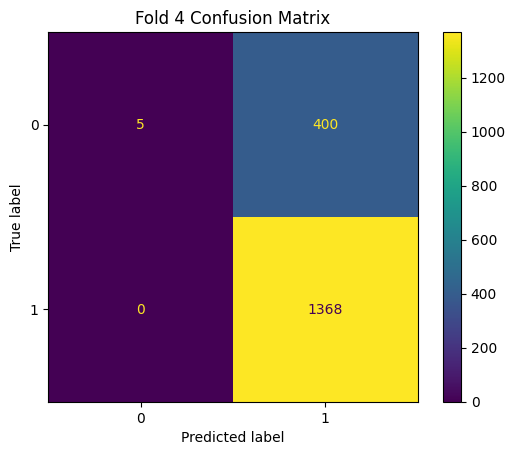

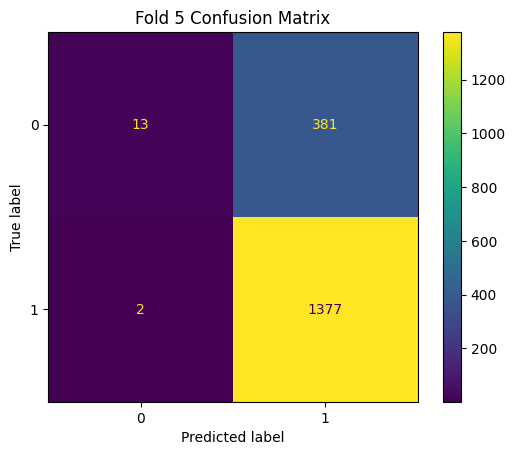

Mean Confusion Matrix:
[[9.0000e+00 3.8220e+02]
 [8.0000e-01 1.3812e+03]]


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np

demo = HistGradientBoostingClassifier(l2_regularization=0.01, learning_rate=0.01, max_depth=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store confusion matrices for each fold
confusion_matrices = []

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled)):
    X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Fit the model
    demo.fit(X_train_fold, y_train_fold)

    # Make predictions
    predictions = demo.predict(X_test_fold)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_fold, predictions)

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)

    # Display the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=demo.classes_)
    disp.plot()
    plt.title(f'Fold {fold + 1} Confusion Matrix')
    plt.show()

# Calculate and print the mean confusion matrix
mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
print('Mean Confusion Matrix:')
print(mean_confusion_matrix)


## Final Model Selection & Evaluation on Test Set

In this concluding step, we retrieve the top-performing model from our ranking list. We then deploy this optimal estimator on the **independent testing set** (`X_testing`)—data that the model has never seen during training or validation.

**Objectives:**
1.  **Inference:** Generate predictions on the unseen data.
2.  **Performance Reporting:** Calculate the final **Accuracy, Precision, Recall, and F1-Score** to quantify the model's generalization capability.
3.  **Error Analysis:** Visualize the **Confusion Matrix** to inspect the distribution of True Positives/Negatives versus False Positives/Negatives, providing a complete picture of the classifier's reliability.

['HistGradientBoostingClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'KNeighborsClassifier', 'SVC', 'LogisticRegression', 'XGBClassifier', 'MLPClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier', 'QuadraticDiscriminantAnalysis', 'GaussianNB']
HistGradientBoostingClassifier(l2_regularization=0.01, learning_rate=0.01,
                               max_depth=10)
Accuracy: 0.5108303249097473, Precision: 0.5054945054945055, Recall: 0.9963898916967509, F1: 0.6707168894289186


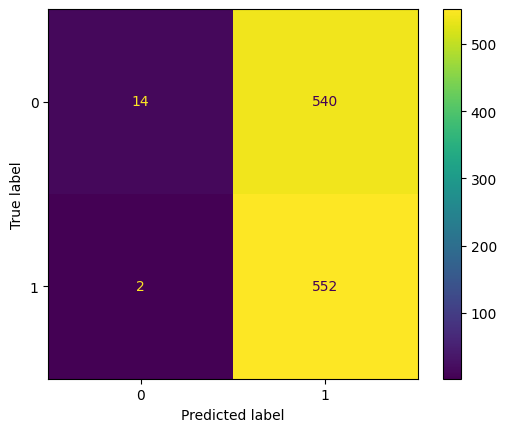

In [9]:
# Sort the models based on their validation scores in descending order (highest accuracy first)
estimators = sorted(best_scores.keys(), key=lambda x: best_scores[x], reverse = True)
print(estimators)

# Retrieve the best estimator object from the dictionary using the name of the top-performing model
best_est = best_estimators[estimators[0]]
print(best_est)

# Use the best estimator to generate predictions on the unseen testing set
predictions = best_est.predict(X_testing_scaled)

# Calculate key performance metrics to evaluate the model's effectiveness
acc = accuracy_score(y_testing, predictions)
precision = precision_score(y_testing, predictions)
recall = recall_score(y_testing, predictions)
f1 = f1_score(y_testing, predictions)

# Print the calculated metrics for review
print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Generate and visualize the confusion matrix to analyze prediction errors (False Positives vs False Negatives)
cm = confusion_matrix(y_testing, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_est.classes_)
disp.plot()

### Hyperparameter Optimization & Baseline Comparison

In this comprehensive optimization stage, we conduct a systematic search for the best model architecture. We define a specific hyperparameter grid (`param_grids`) for six different classifiers, targeting key parameters such as learning rate, tree depth, and regularization terms.

The pipeline executes two parallel evaluations for each model:
1.  **Baseline Evaluation:** We calculate the accuracy of the model using **default parameters** to establish a performance benchmark.
2.  **Grid Search CV:** We perform an exhaustive search (5-Fold Cross-Validation) over the parameter grid to identify the optimal configuration that maximizes accuracy.

Finally, we visualize the results using a **comparative horizontal bar chart**, which illustrates the performance delta between the baseline (default) and the optimized models, enabling us to quantify the improvement achieved through tuning.

Original Accuracy for DecisionTreeClassifier: 0.4540
Grid search for DecisionTreeClassifier...
Best Parameters for DecisionTreeClassifier: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'splitter': 'random'}
Best Accuracy for DecisionTreeClassifier: 0.6030921037153189
Test set accuracy: 0.54


Original Accuracy for RandomForestClassifier: 0.4792
Grid search for RandomForestClassifier...
Best Parameters for RandomForestClassifier: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 200}
Best Accuracy for RandomForestClassifier: 0.6456134259921622
Test set accuracy: 0.52


Original Accuracy for XGBClassifier: 0.4937
Grid search for XGBClassifier...
Best Parameters for XGBClassifier: {'max_depth': 10, 'max_leaves': 5, 'n_estimators': 100, 'scale_pos_weight': 0.38214018458468446}
Best Accuracy for XGBClassifier: 0.6947879090783651
Test set accuracy: 0.62


Original Accuracy for HistGradientBoostingClassifier: 0.5081
Grid search for HistGrad

C:\Users\tasos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Original Accuracy for LogisticRegression: 0.5289
Grid search for LogisticRegression...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Parameters for LogisticRegression: {'class_weight': 'balanced', 'solver': 'liblinear'}
Best Accuracy for LogisticRegression: 0.6362512725328123
Test set accuracy: 0.62




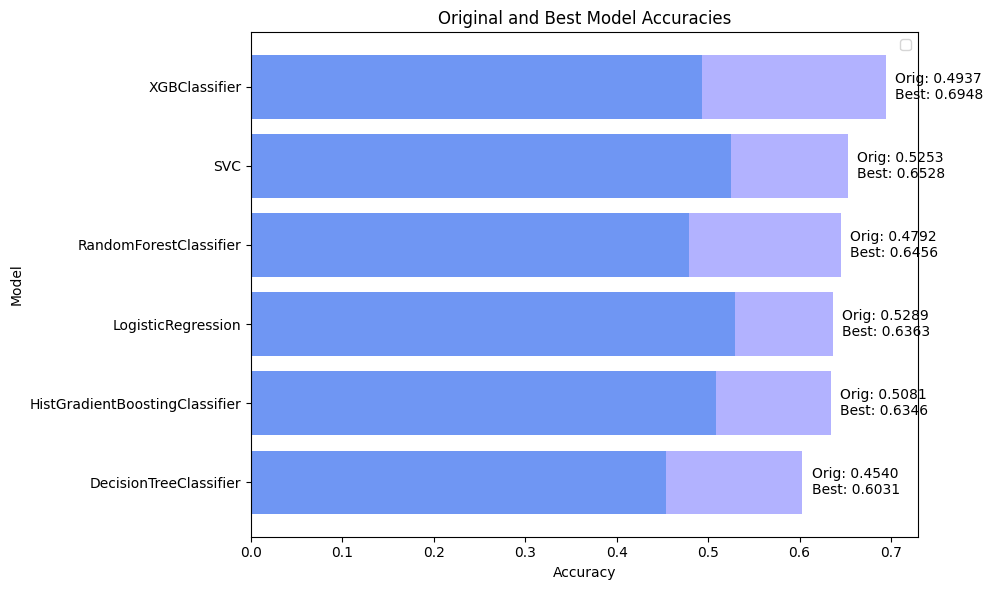

In [10]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          xgb.XGBClassifier(),
          HistGradientBoostingClassifier(),
          svm.SVC(),
          LogisticRegression()
          ]

# Define parameter grids for each model
param_grids = {
    'DecisionTreeClassifier': {'criterion' : ['gini', 'entropy'], 'splitter' : ["best", "random"], 'max_depth' : [20, 50, 100], 'class_weight' : ['balanced']},
    'RandomForestClassifier': {'n_estimators': [100, 150, 200], 'criterion': ['gini', 'entropy'], 'class_weight' : ['balanced', 'balanced_subsample']},
    'XGBClassifier': {'n_estimators' : [100, 150, 200], 'max_depth': [10, 50, 60], 'max_leaves' : [5, 10, 20], 'scale_pos_weight' : [ratio]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_depth': [10, 50, 100], 'l2_regularization' : [0.01, 0.001], 'class_weight' : ['balanced']},
    'SVC': {'kernel': ['poly', 'rbf'], 'degree' : [1, 2], 'C' : [1.5, 2.3], 'tol' : [1e-2, 1e-3], 'class_weight' : ['balanced'], 'random_state' : [42]},
    'LogisticRegression': {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 'class_weight':['balanced']}
}

# Dictionary to store best scores for each model
best_scores = {}
original_accuracies = {}
best_estimators_balanced = {}

# Loop over models
for model in models:
    # Get the model name
    model_name = type(model).__name__

    # Create a pipeline with StandardScaler for each model
    pipeline = make_pipeline(StandardScaler(), model)

    # Fit the original model
    pipeline.fit(X_train_scaled, y_train)

    # Make predictions on the validation set
    predictions = pipeline.predict(X_validation_scaled)

    # Calculate and store the original accuracy
    original_accuracy = accuracy_score(y_validation, predictions)
    original_accuracies[model_name] = original_accuracy

    # Print the original accuracy
    print(f'Original Accuracy for {model_name}: {original_accuracy:.4f}')

    # Print current model
    print(f"Grid search for {model_name}...")

    # Get the parameter grid for the current model
    param_grid = param_grids.get(model_name, {})

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs = -1)

    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)

    # Store the best score in the dictionary
    best_scores[model_name] = grid_search.best_score_

    # Store the best estimators in the dictionary
    best_estimators_balanced[model_name] = grid_search.best_estimator_

    # Evaluate the model on the test set
    test_accuracy = grid_search.score(X_testing_scaled, y_testing)

    # Print the best parameters and the corresponding accuracy
    print(f"Best Parameters for {model_name}:", grid_search.best_params_)
    print(f"Best Accuracy for {model_name}:", grid_search.best_score_)
    print(f"Test set accuracy: {test_accuracy:.2f}")
    print("\n")

# Sort models based on best scores
sorted_models = sorted(best_scores.keys(), key=lambda x: best_scores[x])

# Create a barh plot with transparency in descending order
plt.figure(figsize=(10, 6))

# Plot original accuracies with transparency
bars_original = plt.barh(sorted_models, [original_accuracies[model] for model in sorted_models], color='skyblue', alpha=0.8)

# Plot best scores after grid search in descending order
bars_best = plt.barh(sorted_models, [best_scores[model] for model in sorted_models], color='blue', alpha=0.3)

# Add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Original and Best Model Accuracies')

# Add legend
plt.legend()

# Add text labels to the bars
for bar, orig_acc, best_acc in zip(bars_best, [original_accuracies[model] for model in sorted_models], [best_scores[model] for model in sorted_models]):
    plt.text(bar.get_x() + bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, f'Orig: {orig_acc:.4f}\nBest: {best_acc:.4f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()

### Final Evaluation on Unseen Test Data

After completing the Grid Search and identifying the optimal hyperparameters, we select the top-performing estimator (`best_est_balanced`).

To rigorously assess the model's generalization capability, we deploy it on the **held-out Testing Set** (`X_testing_scaled`). This dataset was completely isolated during the training and validation phases.

**Performance Metrics:**
We calculate a comprehensive set of metrics to evaluate the quality of predictions:
* **Accuracy:** Overall correctness of the model.
* **Precision & Recall:** Critical for drug discovery, where minimizing False Negatives (missing a potential active compound) is often more important than avoiding False Positives.
* **F1-Score:** The harmonic mean of Precision and Recall, providing a single metric for model balance.
* **Confusion Matrix:** A visual representation of True Positives, True Negatives, False Positives, and False Negatives.

['XGBClassifier', 'SVC', 'RandomForestClassifier', 'LogisticRegression', 'HistGradientBoostingClassifier', 'DecisionTreeClassifier']
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy: 0.6245487364620939, Precision: 0.5980113636363636, Recall: 0.759927797833935, F1: 0.6693163751987281


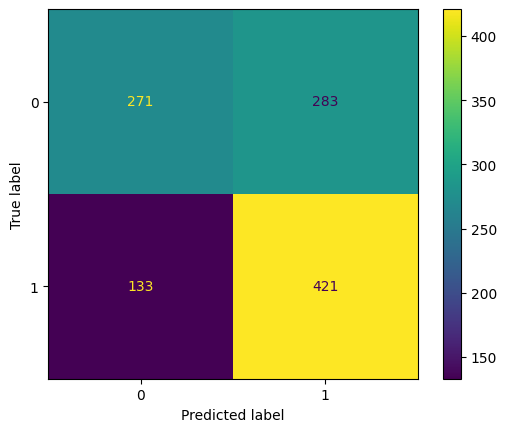

In [11]:
# Sort the models by their best validation score in descending order
estimators_balanced = sorted(best_scores.keys(), key=lambda x: best_scores[x], reverse = True)
print(estimators_balanced)

# Select the highest-performing model (estimator) from the dictionary
best_est_balanced = best_estimators_balanced[estimators_balanced[0]]
print(best_est_balanced)

# Use the best model to predict labels on the unseen testing set
predictions = best_est_balanced.predict(X_testing_scaled)

# Calculate performance metrics on the test data
acc = accuracy_score(y_testing, predictions)
precision = precision_score(y_testing, predictions)
recall = recall_score(y_testing, predictions)
f1 = f1_score(y_testing, predictions)

# Print the final evaluation metrics
print(f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Generate and plot the confusion matrix to visualize prediction performance
cm = confusion_matrix(y_testing, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_est_balanced.classes_)
disp.plot()

## Experimental Section: Deep Learning Approach

In addition to the ensemble methods, we investigated the performance of an **Artificial Neural Network (ANN)**. The goal was to determine if a non-linear Deep Learning architecture could capture complex patterns in the molecular descriptors that the tree-based models might miss.

**Implementation:**
We constructed a Multi-Layer Perceptron (MLP) using dense layers with ReLU activation and Dropout for regularization to prevent overfitting.

**Outcome & Discussion:**
Contrary to the initial hypothesis, the ANN yielded **suboptimal results** compared to the Gradient Boosting classifiers (lower F1-score and convergence issues).

**Why did this happen?**
This behavior is consistent with current literature on **Tabular Data** in Drug Discovery. While Deep Learning excels in unstructured data (images, sequences), **Tree-based ensembles (like XGBoost)** often outperform ANNs on structured datasets with handcrafted features (molecular descriptors). The ANN likely struggled due to:
1.  **Data Volume:** Deep Learning models typically require significantly larger datasets to generalize effectively without overfitting.
2.  **Feature Nature:** Decision trees are naturally more robust to the varying scales and distributions of physicochemical descriptors compared to the sensitive loss landscapes of Neural Networks.

**Conclusion:**
Based on these empirical results, we selected the **HistGradientBoosting / XGBoost** model as the final production candidate, favoring robustness and interpretability over complexity.

**Figure 1:** Training history and loss curves of the experimental ANN approach.
<img src="ann_results_graph.png" width="700">